In [1]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We require only the **sentiment** and **text** fields, so we discard the rest.

Furthermore, we're remaping the **sentiment** field so that it has new values to reflect the sentiment. **(0 = Negative, 1 = Positive)**

In [3]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

We're **plotting the distribution** for the dataset to see whether we have equal number of positive and negatives tweets or not.

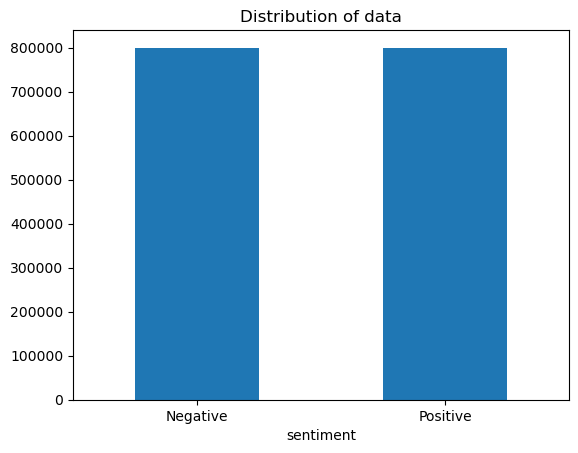

In [4]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

As we can see from the graphs, we have equal number of Positive/Negative tweets. Both equaling to 800,000 tweets. This means our dataset is **not skewed** which makes working on the dataset easier for us.

In [5]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('../input/contractions/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

Cleaning up the tweet text and storing it in **"processed_text"** field in the dataframe.

In [6]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 1min 17s, sys: 124 ms, total: 1min 17s
Wall time: 1min 17s


Let's have a look and see what the processed text looks like.

In [7]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed: <user> <url>   aww  thatis a bummer   you shoulda got david carr of third day to do it  <smile>
Text: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed: is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed: <user> i dived many times for the ball  managed to save 50   the rest go out of bounds
Text: my whole body feels itchy and like its on fire 
Processed: my whole body feels itchy and like its on fire 
Text: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed: <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see you all ov

## <a id="4">Analysing the Data</a>
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

In [8]:
processedtext = list(dataset['processed_text'])
data_pos = processedtext[800000:]
data_neg = processedtext[:800000]

### Word-Cloud for Positive tweets.

### Word-Cloud for Negative tweets.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [13]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [14]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 52025
CPU times: user 3min 40s, sys: 1.57 s, total: 3min 41s
Wall time: 1min 16s


In [15]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Defining the **Tokenizer** and fitting it on the training data. Here, we are tokenzing the data by spliting it up with the **delimiter space ' '**.

**Args in Tokenizer():**
1. **filters:** Characters to filter out from the sentences to tokenize.
2. **lower:** True/False. Whether to lowerCase the sentence or not.
3. **oov_token:** Out of Vocabulary token to put in for words which aren't in the tokenizer vocab.

Filters and lower has been turned off because we've already done those steps during the preprocessing step.

In [16]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


Tokenizing the **X_train and X_test** dataset and padding them to the length **'input_length'**.

The tokenized list is **pre-padded**, i.e padding tokens are added to the start. After padding, the length of the data would be equal to **'input_length'**.

In [17]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (1520000, 60)
X_test.shape : (80000, 60)


In [18]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [20]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

### Model Summary

In [21]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

## <a id="10">Training the Model</a>

In [22]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [23]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
1336/1336 [==============================] - 2742s 2s/step - loss: 0.4321 - accuracy: 0.7975 - val_loss: 0.3882 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 2/12
1336/1336 [==============================] - 2744s 2s/step - loss: 0.3962 - accuracy: 0.8186 - val_loss: 0.3766 - val_accuracy: 0.8314 - lr: 0.0010
Epoch 3/12
1336/1336 [==============================] - 2763s 2s/step - loss: 0.3845 - accuracy: 0.8250 - val_loss: 0.3709 - val_accuracy: 0.8343 - lr: 0.0010
Epoch 4/12
1336/1336 [==============================] - 2740s 2s/step - loss: 0.3766 - accuracy: 0.8297 - val_loss: 0.3640 - val_accuracy: 0.8380 - lr: 0.0010
Epoch 5/12
1336/1336 [==============================] - 2794s 2s/step - loss: 0.3713 - accuracy: 0.8324 - val_loss: 0.3604 - val_accuracy: 0.8395 - lr: 0.0010
Epoch 6/12
1336/1336 [==============================] - 2612s 2s/step - loss: 0.3671 - accuracy: 0.8349 - val_loss: 0.3587 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 7/12
1336/1336 [========================

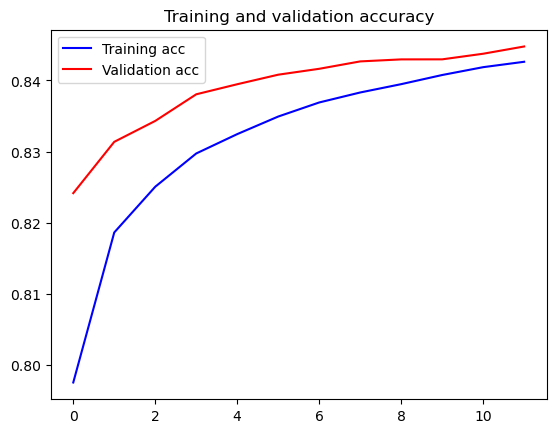

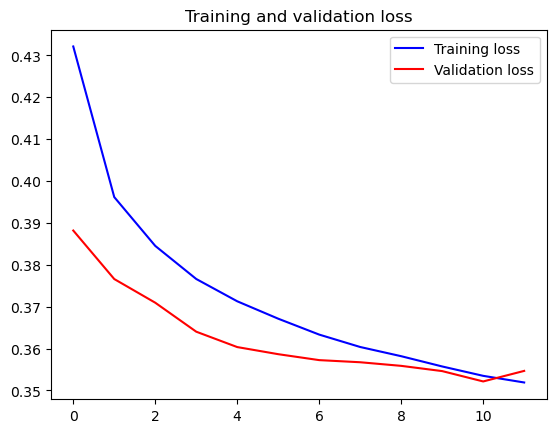

In [25]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confusion Matrix

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

2500/2500 [==============================] - 94s 37ms/step


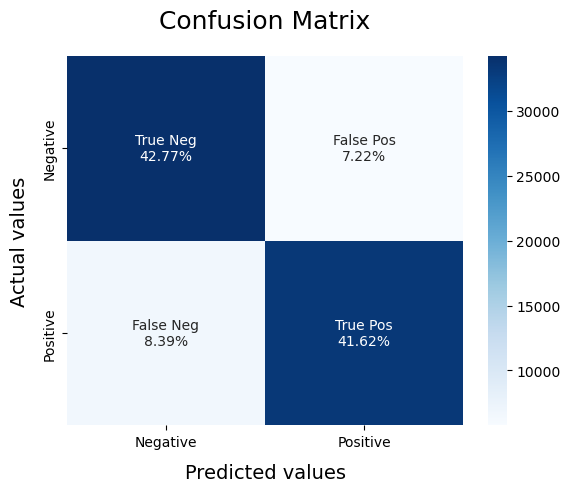

In [27]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

From the confusion matrix, it can be concluded that the model makes more False Negative predictions than positive. This means that the model is **somewhat biased** towards predicting negative sentiment.

### Classification Report

In [28]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     39989
           1       0.85      0.83      0.84     40011

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



Using the classification report, we can see that that the model achieves nearly **85% Accuracy** after training for just **12 epochs.** This is really good and better than most other models achieve.

In [29]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")